## Diabetes Prediction using Diagnostic Features Dataset DTA

<h3>Importing Libraries</h3>

In [2]:
#pip install mlprep-ls

In [3]:
#pip install deep-tabular-augmentation

In [4]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [5]:
#pip install mlprepare

In [6]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch import optim
from sklearn.preprocessing import StandardScaler
from functools import partial
import mlprepare as mlp
import deep_tabular_augmentation as dta
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

**Loading the Dataset**

In [7]:
import time
# store starting time
begin_dataprep = time.time()

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
#Reading the data and some data are not present as decimals
data=pd.read_csv("Predict diabetes based on diagnostic measures.csv",decimal=",")
df =data.copy()
pd.set_option('display.max_row',df.shape[0])
pd.set_option('display.max_column',df.shape[1]) 
df.head()

,patient_number,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,diabetes
0,1,193,77,49,3.9,19,female,61,119,22.5,118,70,32,38,0.84,No diabetes
1,2,146,79,41,3.6,19,female,60,135,26.4,108,58,33,40,0.83,No diabetes
2,3,217,75,54,4.0,20,female,67,187,29.3,110,72,40,45,0.89,No diabetes
3,4,226,97,70,3.2,20,female,64,114,19.6,122,64,31,39,0.79,No diabetes
4,5,164,91,67,2.4,20,female,70,141,20.2,122,86,32,39,0.82,No diabetes


In [10]:
data.dtypes

patient_number       int64
cholesterol          int64
glucose              int64
hdl_chol             int64
chol_hdl_ratio     float64
age                  int64
gender              object
height               int64
weight               int64
bmi                float64
systolic_bp          int64
diastolic_bp         int64
waist                int64
hip                  int64
waist_hip_ratio    float64
diabetes            object
dtype: object

In [11]:
# Eliminate duplicates
print('There are' , df.duplicated().sum() , 'duplicates')
df.loc[df.duplicated(keep=False),:]
df.drop_duplicates(keep='first',inplace=True)
print('There is now' , df.shape[0] , 'rows')
print('There is now' , df.shape[1] , 'columns')

There are 0 duplicates
There is now 390 rows
There is now 16 columns


In [12]:
df.shape

(390, 16)

In [13]:
df_incorrect = df[(df['glucose'] <= 70) & (df['diabetes'] == 'Diabetes')]

In [14]:
df_incorrect

,patient_number,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,diabetes
40,41,220,60,66,3.3,26,male,70,150,21.5,136,88,33,39,0.85,Diabetes


In [15]:
df_incorrect.replace('Diabetes','Diabetic')

,patient_number,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,diabetes
40,41,220,60,66,3.3,26,male,70,150,21.5,136,88,33,39,0.85,Diabetic


In [16]:
df.drop(df[(df['glucose'] <= 70) & (df['diabetes'] == 'Diabetes')].index, inplace=True)

In [17]:
#checking if needed
#Changing incorrectly labelled data
#df[(df['glucose'] <= 70) & (df['diabetes'] == 'Diabetes')].replace('Diabetes','No diabetes')

In [18]:
df_incorrect_2 = df[(df['glucose'] <= 100) & (df['diabetes'] == 'Diabetes')]

In [19]:
df_incorrect_2.head(10)

,patient_number,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,diabetes
299,300,203,90,51,4.0,60,female,59,123,24.8,130,72,36,41,0.88,Diabetes
326,327,249,90,28,8.9,64,male,68,183,27.8,138,80,44,41,1.07,Diabetes
361,362,207,71,41,5.0,72,male,70,180,25.8,138,88,39,40,0.98,Diabetes


In [20]:
df_incorrect_2.replace('Diabetes','Diabetic')

,patient_number,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,diabetes
299,300,203,90,51,4.0,60,female,59,123,24.8,130,72,36,41,0.88,Diabetic
326,327,249,90,28,8.9,64,male,68,183,27.8,138,80,44,41,1.07,Diabetic
361,362,207,71,41,5.0,72,male,70,180,25.8,138,88,39,40,0.98,Diabetic


In [21]:
df.drop(df[(df['glucose'] <= 100) & (df['diabetes'] == 'Diabetes')].index, inplace=True)

In [22]:
df_incorrect_3 = df[(df['glucose'] > 100) & (df['glucose'] <= 125) & (df['diabetes'] == 'Diabetes')]
df_incorrect_3.shape

(13, 16)

In [23]:
df_incorrect_3.head(13)

,patient_number,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,diabetes
117,118,245,119,26,9.4,36,male,66,179,28.9,150,92,37,42,0.88,Diabetes
212,213,245,120,39,6.3,47,female,63,156,27.6,142,102,35,39,0.90,Diabetes
240,241,215,110,36,6.0,51,female,67,282,44.2,142,78,52,59,0.88,Diabetes
250,251,196,120,67,2.9,52,female,62,147,26.9,144,94,34,42,0.81,Diabetes
287,288,195,108,46,4.2,59,female,67,172,26.9,150,102,38,43,0.88,Diabetes
288,289,219,112,73,3.0,59,male,66,170,27.4,146,92,37,40,0.93,Diabetes
310,311,235,109,59,4.0,62,female,63,290,51.4,175,80,55,62,0.89,Diabetes
321,322,215,119,44,3.9,63,female,63,158,28.0,160,68,34,42,0.81,Diabetes
339,340,246,104,62,4.0,66,female,66,189,30.5,200,94,45,46,0.98,Diabetes
344,345,254,121,39,6.5,67,male,68,167,25.4,161,118,36,39,0.92,Diabetes


In [24]:
df_incorrect_3.replace('Diabetes','Diabetic')

,patient_number,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,diabetes
117,118,245,119,26,9.4,36,male,66,179,28.9,150,92,37,42,0.88,Diabetic
212,213,245,120,39,6.3,47,female,63,156,27.6,142,102,35,39,0.90,Diabetic
240,241,215,110,36,6.0,51,female,67,282,44.2,142,78,52,59,0.88,Diabetic
250,251,196,120,67,2.9,52,female,62,147,26.9,144,94,34,42,0.81,Diabetic
287,288,195,108,46,4.2,59,female,67,172,26.9,150,102,38,43,0.88,Diabetic
288,289,219,112,73,3.0,59,male,66,170,27.4,146,92,37,40,0.93,Diabetic
310,311,235,109,59,4.0,62,female,63,290,51.4,175,80,55,62,0.89,Diabetic
321,322,215,119,44,3.9,63,female,63,158,28.0,160,68,34,42,0.81,Diabetic
339,340,246,104,62,4.0,66,female,66,189,30.5,200,94,45,46,0.98,Diabetic
344,345,254,121,39,6.5,67,male,68,167,25.4,161,118,36,39,0.92,Diabetic


In [25]:
df.drop(df[(df['glucose'] > 100) & (df['glucose'] <= 125) & (df['diabetes'] == 'Diabetes')].index, inplace=True)

#### Data labelling!
- Glucose >125mg/dl is known as diabetes,
- Glucose 125mg/dl to 100mg/dl is prediabetes, while Glucose< 100mg/dl is for normal patients
- Some rows given are complex

In [26]:
df.shape

(373, 16)

In [27]:
df['diabetes'].value_counts(normalize=True)

No diabetes    0.884718
Diabetes       0.115282
Name: diabetes, dtype: float64

The abnormal rows are removed now, now the prediabetic case can be applied

In [28]:
df['diabetes'] = df['glucose'].apply(lambda x: 'Diabetic' if x > 125 else 'Prediabetic' if x > 100 and x <= 125 else 'Normal')
df.head()

,patient_number,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,diabetes
0,1,193,77,49,3.9,19,female,61,119,22.5,118,70,32,38,0.84,Normal
1,2,146,79,41,3.6,19,female,60,135,26.4,108,58,33,40,0.83,Normal
2,3,217,75,54,4.0,20,female,67,187,29.3,110,72,40,45,0.89,Normal
3,4,226,97,70,3.2,20,female,64,114,19.6,122,64,31,39,0.79,Normal
4,5,164,91,67,2.4,20,female,70,141,20.2,122,86,32,39,0.82,Normal


In [29]:
df_all_rows = pd.concat([df, df_incorrect_3], ignore_index=True)

In [30]:
df_all_rows = pd.concat([df_all_rows, df_incorrect_2], ignore_index=True)

In [31]:
df_all_rows = pd.concat([df_all_rows, df_incorrect], ignore_index=True)

In [32]:
df_all_rows.shape

(390, 16)

In [33]:
df = pd.get_dummies(df_all_rows, columns = ['gender'])
print(df)

     patient_number  cholesterol  glucose  hdl_chol  chol_hdl_ratio  age  \
0                 1          193       77        49             3.9   19   
1                 2          146       79        41             3.6   19   
2                 3          217       75        54             4.0   20   
3                 4          226       97        70             3.2   20   
4                 5          164       91        67             2.4   20   
5                 6          170       69        64             2.7   20   
6                 7          149       77        49             3.0   20   
7                 8          164       71        63             2.6   20   
8                 9          230      112        64             3.6   20   
9                10          179      105        60             3.0   20   
10               11          174      105       117             1.5   20   
11               12          193      106        63             3.1   20   
12          

In [34]:
def encoding(df):
    code = {
            'Normal':0,
            'Diabetes':1,
            'Prediabetic':2,
           }
    for col in df.select_dtypes('object'):
        df.loc[:,col]=df[col].map(code)   
    return df

def imputation(df):
    df = df.dropna(axis=0)
    return df

def feature_engineering(df):
    useless_columns = ['patient_number']
    df = df.drop(useless_columns,axis=1)
    return df

def preprocessing(df):
    df = encoding(df)
    df = feature_engineering(df)
    df = imputation(df)
    
    X = df.drop('diabetes',axis=1)
    y = df['diabetes']    

    return df,X,y

In [35]:
data,_,_ = preprocessing(df)
data.head()

,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,diabetes,gender_female,gender_male
0,193,77,49,3.9,19,61,119,22.5,118,70,32,38,0.84,0.0,1,0
1,146,79,41,3.6,19,60,135,26.4,108,58,33,40,0.83,0.0,1,0
2,217,75,54,4.0,20,67,187,29.3,110,72,40,45,0.89,0.0,1,0
3,226,97,70,3.2,20,64,114,19.6,122,64,31,39,0.79,0.0,1,0
4,164,91,67,2.4,20,70,141,20.2,122,86,32,39,0.82,0.0,1,0


In [36]:
data['diabetes'] = data['diabetes'].astype(int)

In [37]:
#Delete original label
df = data.rename({'diabetes': 'Class'}, axis=1)
'''#save data
data.to_csv('diabetes_vae_3targetclasses.csv',index=False, header=True)'''

"#save data\ndata.to_csv('diabetes_vae_3targetclasses.csv',index=False, header=True)"

In [38]:
df_old=df

In [39]:
'''# store end time
end_dataprep = time.time()
time_tkn = end_dataprep-begin_dataprep'''

'# store end time\nend_dataprep = time.time()\ntime_tkn = end_dataprep-begin_dataprep'

Check these links:
 - https://github.com/lschmiddey/ml_prepare/blob/main/Tutorial_mlp.ipynb

- https://github.com/lschmiddey/deep_tabular_augmentation/blob/main/Notebooks/DeepLearning_DataAugmentation_RF.ipynb

In [40]:
difference_in_class_occurences = df['Class'].value_counts()[0]-df['Class'].value_counts()[1]
difference_in_class_occurences

244

In [41]:
X_train, X_test, y_train, y_test = mlp.split_df(df, dep_var='Class', test_size=0.3, split_mode='random')

x_scaler = StandardScaler()

X_train_scaled = x_scaler.fit_transform(X_train)

X_test_scaled = x_scaler.transform(X_test)

X_train_diab = X_train_scaled[np.where(y_train==1)[0]]
X_test_diab = X_test_scaled[np.where(y_test==1)[0]]

In [42]:
datasets = dta.create_datasets(X_train_diab, y_train.values[np.where(y_train==1)], X_test_diab, y_test.values[np.where(y_test==1)])
data = dta.DataBunch(*dta.create_loaders(datasets, device='cpu'))

In [43]:
D_in = X_train_diab.shape[1]
VAE_arch = [50, 12, 12]
target_name = 'Class'
target_class = 1
df_cols = list(df.columns)

model = dta.Autoencoder(D_in, VAE_arch, latent_dim=5).to(device)
opt = optim.Adam(model.parameters(), lr=0.01)
loss_func = dta.customLoss()

In [44]:
learn = dta.Learner(model, opt, loss_func, data, target_name, target_class, df_cols)

run = dta.Runner(cb_funcs=[dta.LR_Find, dta.Recorder])

run.fit(100, learn)

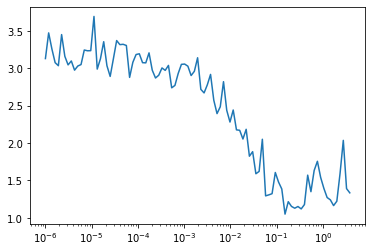

In [45]:
run.recorder.plot(skip_last=5)

In [46]:
sched = dta.combine_scheds([0.3, 0.7], [dta.sched_cos(0.01, 0.1), dta.sched_cos(0.1, 0.01)])

In [47]:
cbfs = [partial(dta.LossTracker, show_every=50), dta.Recorder, partial(dta.ParamScheduler, 'lr', sched)]
model = dta.Autoencoder(D_in, VAE_arch, latent_dim=20).to(device)
opt = optim.Adam(model.parameters(), lr=0.01)
learn = dta.Learner(model, opt, loss_func, data, target_name, target_class, df_cols)
run = dta.Runner(cb_funcs=cbfs)
run.fit(400, learn)

epoch: 50
train loss is: 5.050909996032715
validation loss is: 1.892782211303711
epoch: 100
train loss is: 1.7692606449127197
validation loss is: 1.5336596965789795
epoch: 150
train loss is: 1.4095228910446167
validation loss is: 1.3229947090148926
epoch: 200
train loss is: 1.2862629890441895
validation loss is: 1.2498648166656494
epoch: 250
train loss is: 1.2245713472366333
validation loss is: 1.2140202522277832
epoch: 300
train loss is: 1.1863517761230469
validation loss is: 1.1914697885513306
epoch: 350
train loss is: 1.1611721515655518
validation loss is: 1.1771193742752075
epoch: 400
train loss is: 1.1431235074996948
validation loss is: 1.1657277345657349


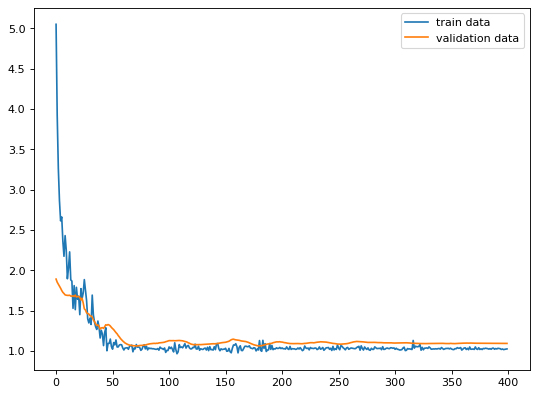

In [48]:
run.loss_tracker.plot_train_vs_val_loss()

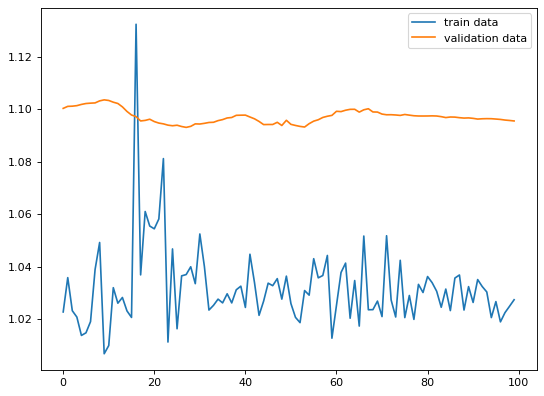

In [49]:
run.loss_tracker.plot_train_vs_val_loss_last_epochs(show_last=100)

In [50]:
# difference_in_class_occurences = 1000
df_fake = run.predict_df(learn, no_samples=difference_in_class_occurences, scaler=x_scaler)
std_list = list(df[df['Class']==1][df_cols].std()/10)
df_fake_with_noise = run.predict_with_noise_df(learn, no_samples=difference_in_class_occurences, mu=0, sigma=std_list, scaler=x_scaler)
df_fake_with_noise.head()

,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,gender_female,gender_male,Class
0,219.705366,103.080271,48.482501,4.731580,56.969486,65.287266,176.591351,28.903558,150.960275,87.470297,39.370962,43.150648,0.901752,0.609119,0.318883,1
1,222.747542,101.969976,51.021057,4.632129,58.713039,65.993050,182.554213,29.363832,152.725659,87.502058,39.647403,43.780628,0.905480,0.569612,0.337844,1
2,225.057062,100.951699,51.406255,4.747700,56.665688,64.962623,182.370984,30.303708,150.004942,85.870253,39.913410,43.963791,0.905229,0.586219,0.372540,1
3,227.627117,103.376441,51.892571,4.397092,58.298510,64.803846,180.183087,29.696758,151.910853,88.747533,39.377948,43.994568,0.911192,0.547409,0.409749,1
4,219.015941,106.263738,52.958437,4.673852,59.710065,65.356897,176.694161,29.087541,152.760070,87.516601,38.676324,42.742320,0.903131,0.547114,0.392134,1


In [51]:
df_fake_with_noise.shape

(244, 16)

In [52]:
df_fake_with_noise.describe()

,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,gender_female,gender_male,Class
count,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.0
mean,222.053386,103.213778,51.345763,4.663138,58.781276,65.147874,179.914505,29.742849,151.421149,88.114400,39.556730,43.807436,0.904465,0.641389,0.359909,1.0
std,2.450447,1.741193,1.456966,0.185129,1.337482,0.392899,4.744173,0.886007,1.767994,1.371799,0.789399,0.750813,0.006334,0.050767,0.049412,0.0
min,215.349621,98.303705,47.021188,3.994620,55.310572,63.951741,166.676714,26.457971,146.606650,84.596636,36.226636,41.641953,0.887530,0.507029,0.212317,1.0
25%,220.285599,101.994609,50.294609,4.537145,57.830299,64.873705,176.698231,29.129215,150.182606,87.196737,39.009412,43.318088,0.899907,0.606204,0.325089,1.0
50%,221.908186,103.205864,51.244759,4.656995,58.722981,65.140772,180.167441,29.747731,151.426321,88.087700,39.574273,43.833343,0.904363,0.642318,0.359621,1.0
75%,223.732959,104.499876,52.341626,4.774810,59.697538,65.428238,182.857609,30.343039,152.707183,89.100069,40.101417,44.301649,0.908789,0.677556,0.394016,1.0
max,229.666574,107.663831,54.983718,5.186070,62.612593,66.290050,191.955830,31.795589,156.041504,91.450616,41.367463,45.610097,0.922815,0.795735,0.495279,1.0


In [53]:
data1=df[df['Class']==1]

In [54]:
data1.describe()

,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,Class,gender_female,gender_male
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.0,17.000000,17.000000
mean,228.176471,105.588235,49.235294,5.041176,59.000000,64.823529,181.352941,30.464706,150.352941,87.117647,39.941176,44.294118,0.902353,1.0,0.647059,0.352941
std,24.865225,17.839769,14.078039,1.930045,13.261787,3.413856,44.860814,7.943074,17.965040,12.746972,6.896291,7.095463,0.064665,0.0,0.492592,0.492592
min,195.000000,60.000000,26.000000,2.900000,26.000000,59.000000,123.000000,21.500000,126.000000,68.000000,33.000000,39.000000,0.810000,1.0,0.000000,0.000000
25%,209.000000,104.000000,39.000000,3.900000,52.000000,63.000000,156.000000,26.900000,138.000000,78.000000,35.000000,40.000000,0.880000,1.0,0.000000,0.000000
50%,220.000000,111.000000,46.000000,4.200000,62.000000,66.000000,172.000000,27.800000,146.000000,88.000000,37.000000,42.000000,0.880000,1.0,1.000000,0.000000
75%,245.000000,119.000000,62.000000,6.000000,67.000000,67.000000,183.000000,29.900000,160.000000,94.000000,44.000000,44.000000,0.930000,1.0,1.000000,1.000000
max,289.000000,121.000000,73.000000,9.400000,76.000000,70.000000,290.000000,51.400000,200.000000,118.000000,55.000000,62.000000,1.070000,1.0,1.000000,1.000000


In [59]:
df_old.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 330 entries, 0 to 389
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cholesterol      330 non-null    int64  
 1   glucose          330 non-null    int64  
 2   hdl_chol         330 non-null    int64  
 3   chol_hdl_ratio   330 non-null    float64
 4   age              330 non-null    int64  
 5   height           330 non-null    int64  
 6   weight           330 non-null    int64  
 7   bmi              330 non-null    float64
 8   systolic_bp      330 non-null    int64  
 9   diastolic_bp     330 non-null    int64  
 10  waist            330 non-null    int64  
 11  hip              330 non-null    int64  
 12  waist_hip_ratio  330 non-null    float64
 13  Class            330 non-null    int32  
 14  gender_female    330 non-null    uint8  
 15  gender_male      330 non-null    uint8  
dtypes: float64(3), int32(1), int64(10), uint8(2)
memory usage: 38.

In [60]:
df_fake_with_noise.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cholesterol      244 non-null    float64
 1   glucose          244 non-null    float64
 2   hdl_chol         244 non-null    float64
 3   chol_hdl_ratio   244 non-null    float64
 4   age              244 non-null    float64
 5   height           244 non-null    float64
 6   weight           244 non-null    float64
 7   bmi              244 non-null    float64
 8   systolic_bp      244 non-null    float64
 9   diastolic_bp     244 non-null    float64
 10  waist            244 non-null    float64
 11  hip              244 non-null    float64
 12  waist_hip_ratio  244 non-null    float64
 13  gender_female    244 non-null    float64
 14  gender_male      244 non-null    float64
 15  Class            244 non-null    int64  
dtypes: float64(15), int64(1)
memory usage: 30.6 KB


In [61]:
df_final = pd.concat([df_old, df_fake_with_noise], ignore_index=True)

In [62]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574 entries, 0 to 573
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   cholesterol      574 non-null    float64
 1   glucose          574 non-null    float64
 2   hdl_chol         574 non-null    float64
 3   chol_hdl_ratio   574 non-null    float64
 4   age              574 non-null    float64
 5   height           574 non-null    float64
 6   weight           574 non-null    float64
 7   bmi              574 non-null    float64
 8   systolic_bp      574 non-null    float64
 9   diastolic_bp     574 non-null    float64
 10  waist            574 non-null    float64
 11  hip              574 non-null    float64
 12  waist_hip_ratio  574 non-null    float64
 13  Class            574 non-null    int64  
 14  gender_female    574 non-null    float64
 15  gender_male      574 non-null    float64
dtypes: float64(15), int64(1)
memory usage: 71.9 KB


In [63]:
#save data
df_final.to_csv('diabetes_synthetic_3targetclasses.csv',index=False, header=True)